In [1]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [29]:
block_size = 3
X, Y = [], []

for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix] # slide the context
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [82]:
# build the dataset
import random

def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] # slide the context

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [30]:
C = torch.randn((27, 2))

In [7]:
emb = C[X]

In [8]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [9]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[ 0.6427, -0.9952, -0.8619,  ...,  0.9925,  0.7820,  0.8968],
        [-0.9992, -0.9483, -0.5402,  ...,  1.0000,  0.9999, -0.6575],
        [-0.8646, -0.9982,  0.9812,  ...,  0.9952,  0.8623, -1.0000],
        ...,
        [ 0.8229, -0.9989, -0.3877,  ...,  0.9853, -0.2132, -0.5743],
        [ 0.5075, -0.9997,  0.4240,  ...,  0.9884,  0.0257, -0.8477],
        [ 0.9472, -0.9961,  0.6296,  ...,  0.8943, -0.4815, -0.9761]])

In [10]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [11]:
logits = h @ W2 + b2

In [12]:
counts = logits.exp()

In [13]:
prob = counts / counts.sum(1, keepdim=True)

In [14]:
prob.shape

torch.Size([16, 27])

In [15]:
loss = -prob[torch.arange(16), Y].log().mean()
loss

tensor(16.4342)

In [31]:
Xtr.shape, Ytr.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [129]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [130]:
sum(p.nelement() for p in parameters)

11897

In [131]:
for p in parameters:
    p.requires_grad = True

In [132]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [133]:
lri = []
lossi = []
stepi = []

In [134]:


for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (64,))
    
    # forward
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(16), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[i]
    if i < 100000:
        lr = 0.1
    else:
        lr = 0.01
        
    # update
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lr)
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss.item())

2.1843791007995605


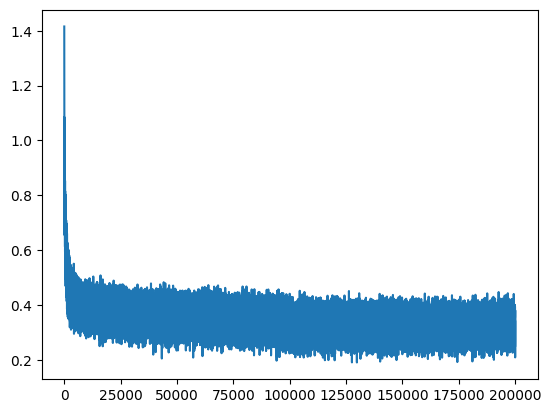

In [135]:
plt.plot(stepi, lossi)

In [136]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.1587977409362793

In [137]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.1211814880371094

In [ ]:
# training split, dev/val split, test split
# 80%, 10%, 10%


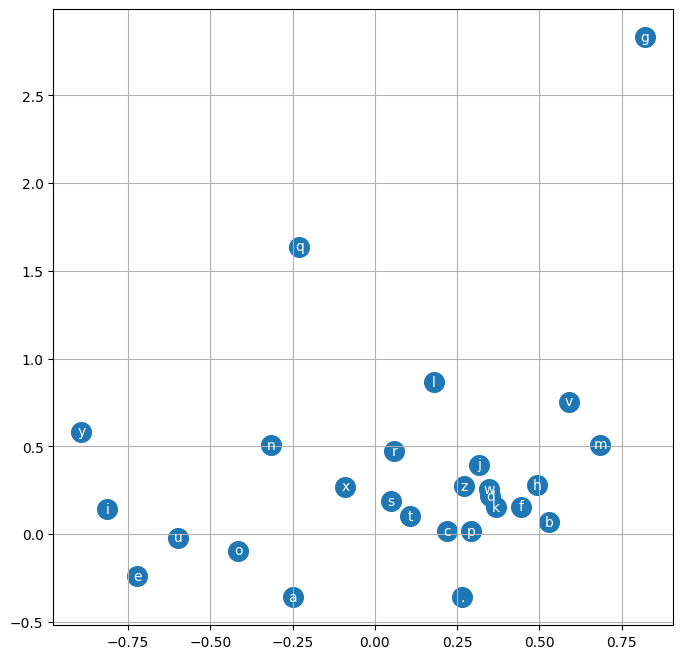

In [111]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [144]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

carlah.
amorie.
khirmin.
reviyah.
cassie.
rahnen.
den.
arci.
aqui.
nellara.
chaiiv.
kaleigh.
ham.
jors.
quint.
shon.
walian.
quintero.
dearynix.
kae.
